#Run this cell first#

In [3]:
!pip install opencv-contrib-python
!pip install pytesseract
!apt install tesseract-ocr
!sudo apt-get install tesseract-ocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 22 not upgraded.
Need to get 4,850 kB of archives.
After this operation, 16.3 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1 [1,598 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 tesseract-ocr amd64 4.1.1-2build2 [262 kB]
Fetched 4,850 k

Main Code - please upload the image, and the OCR model.

Original Image:


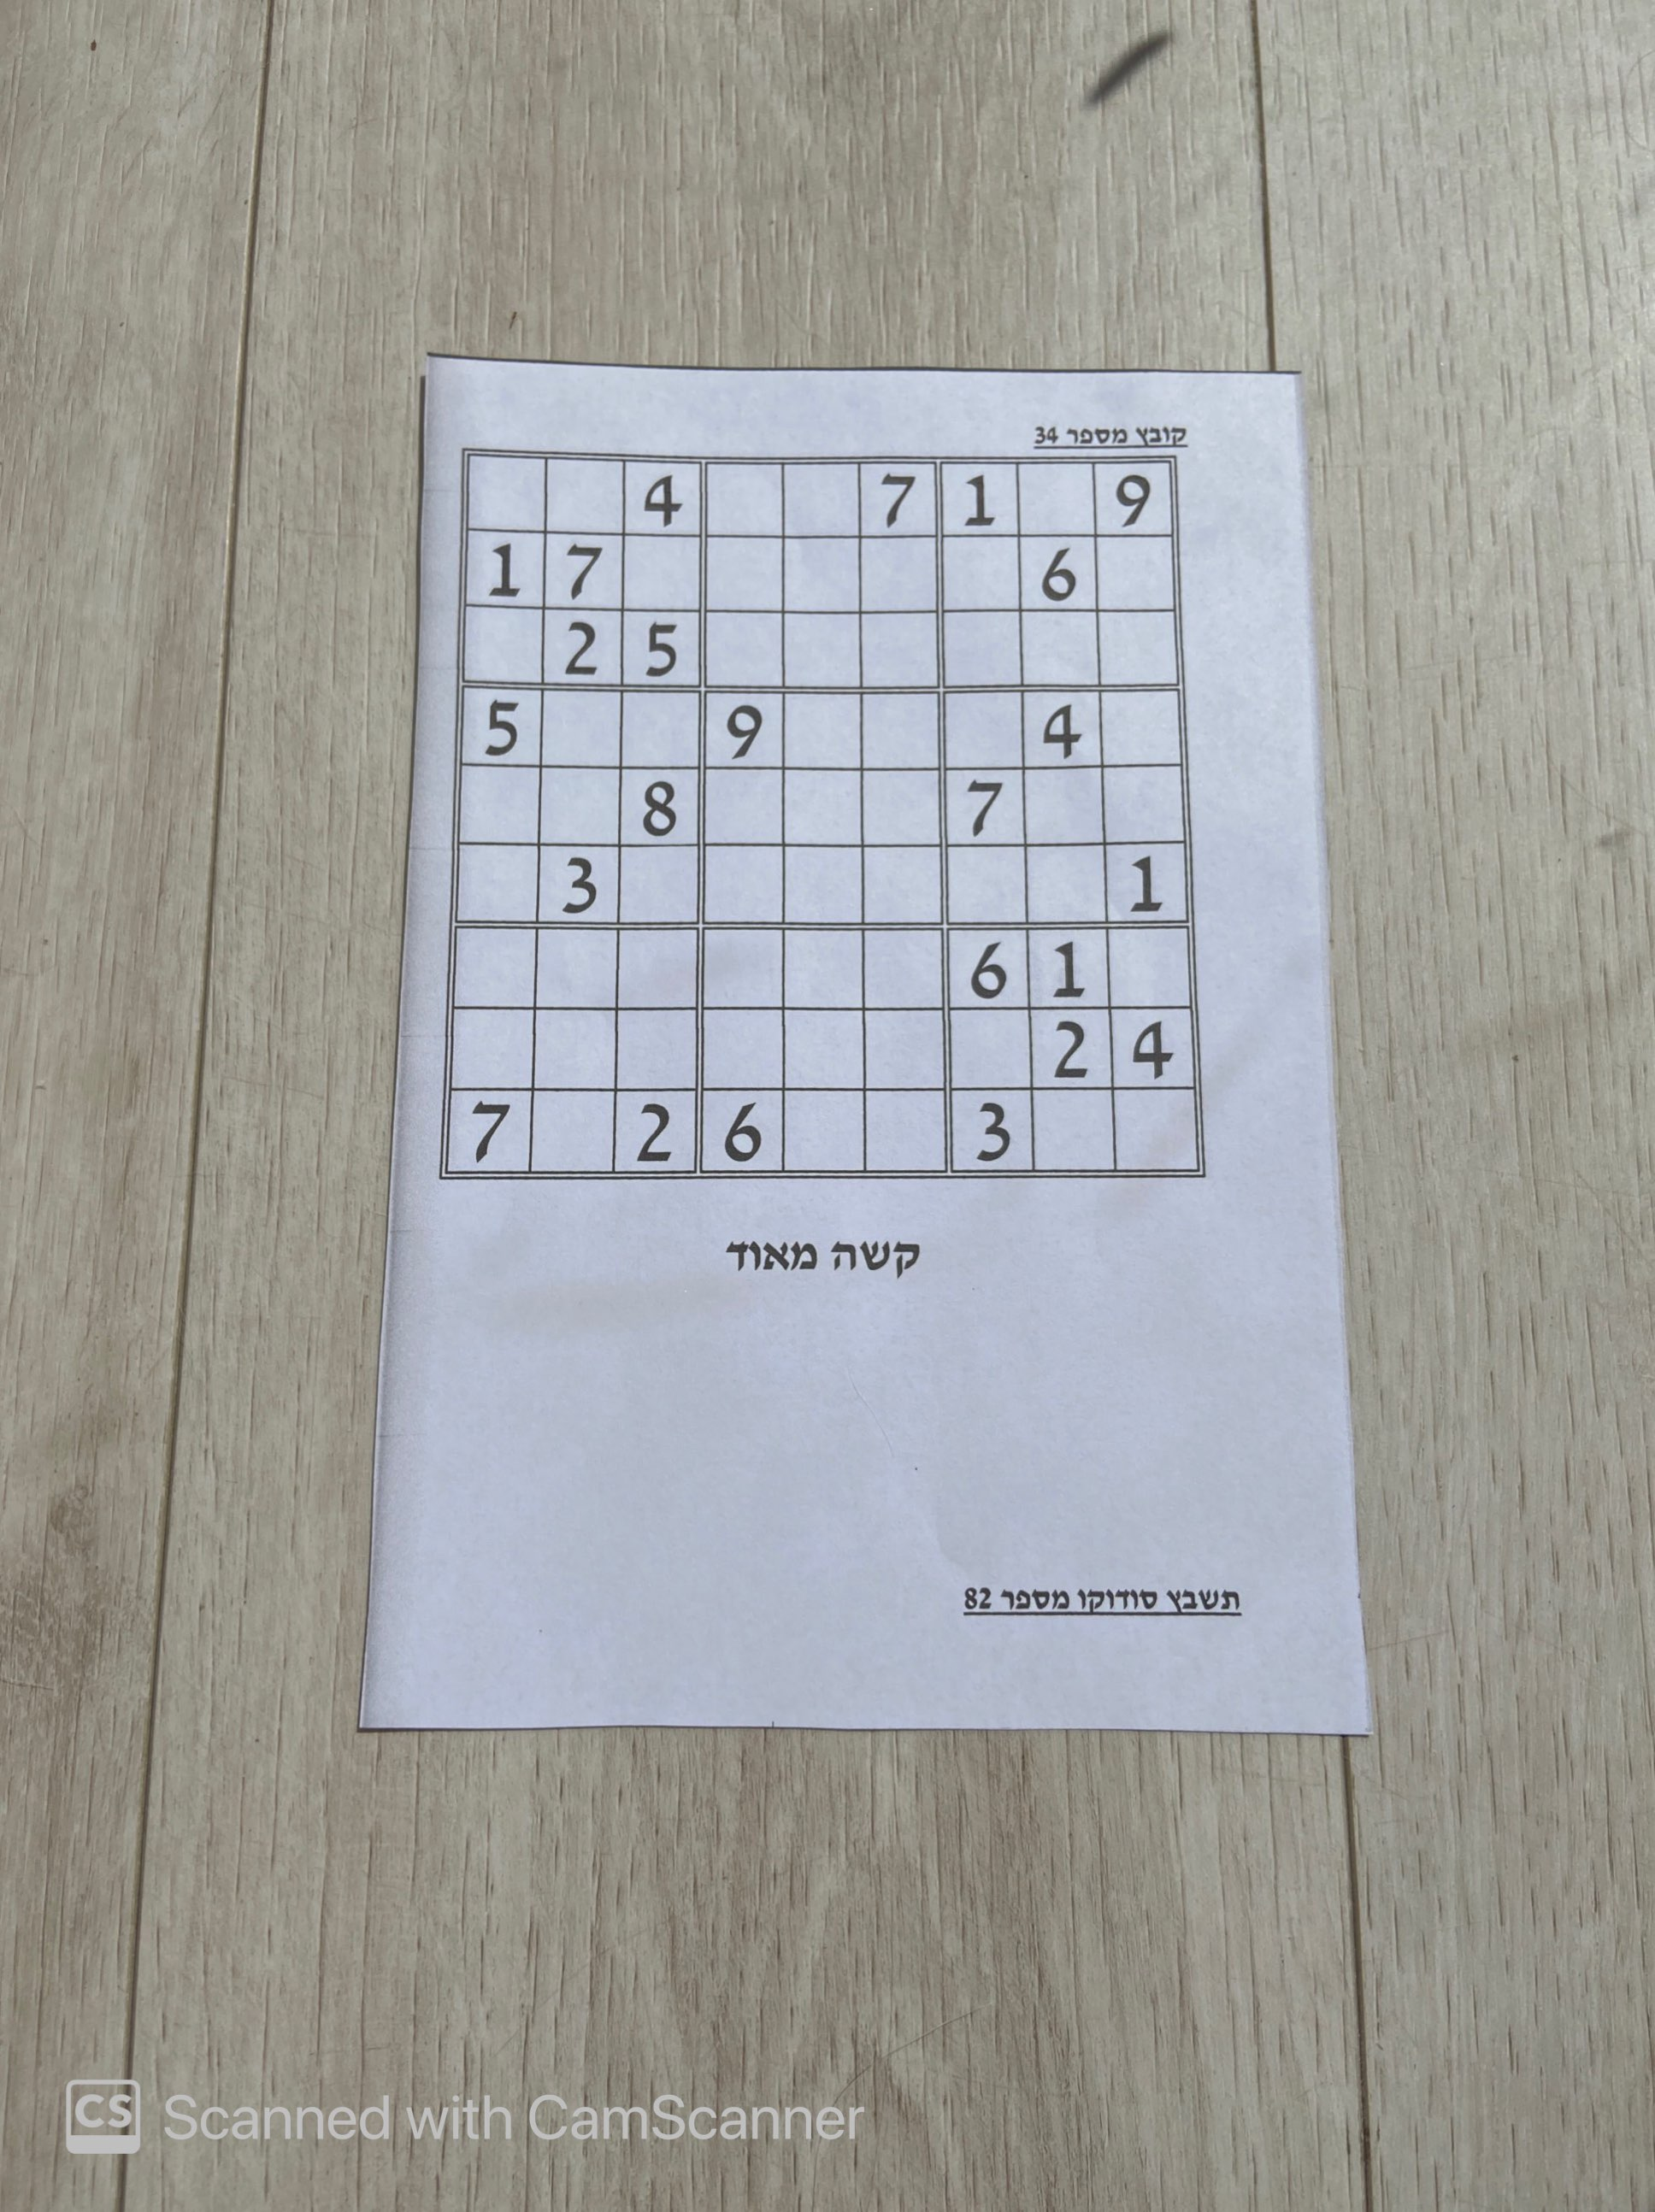

Contours Image:


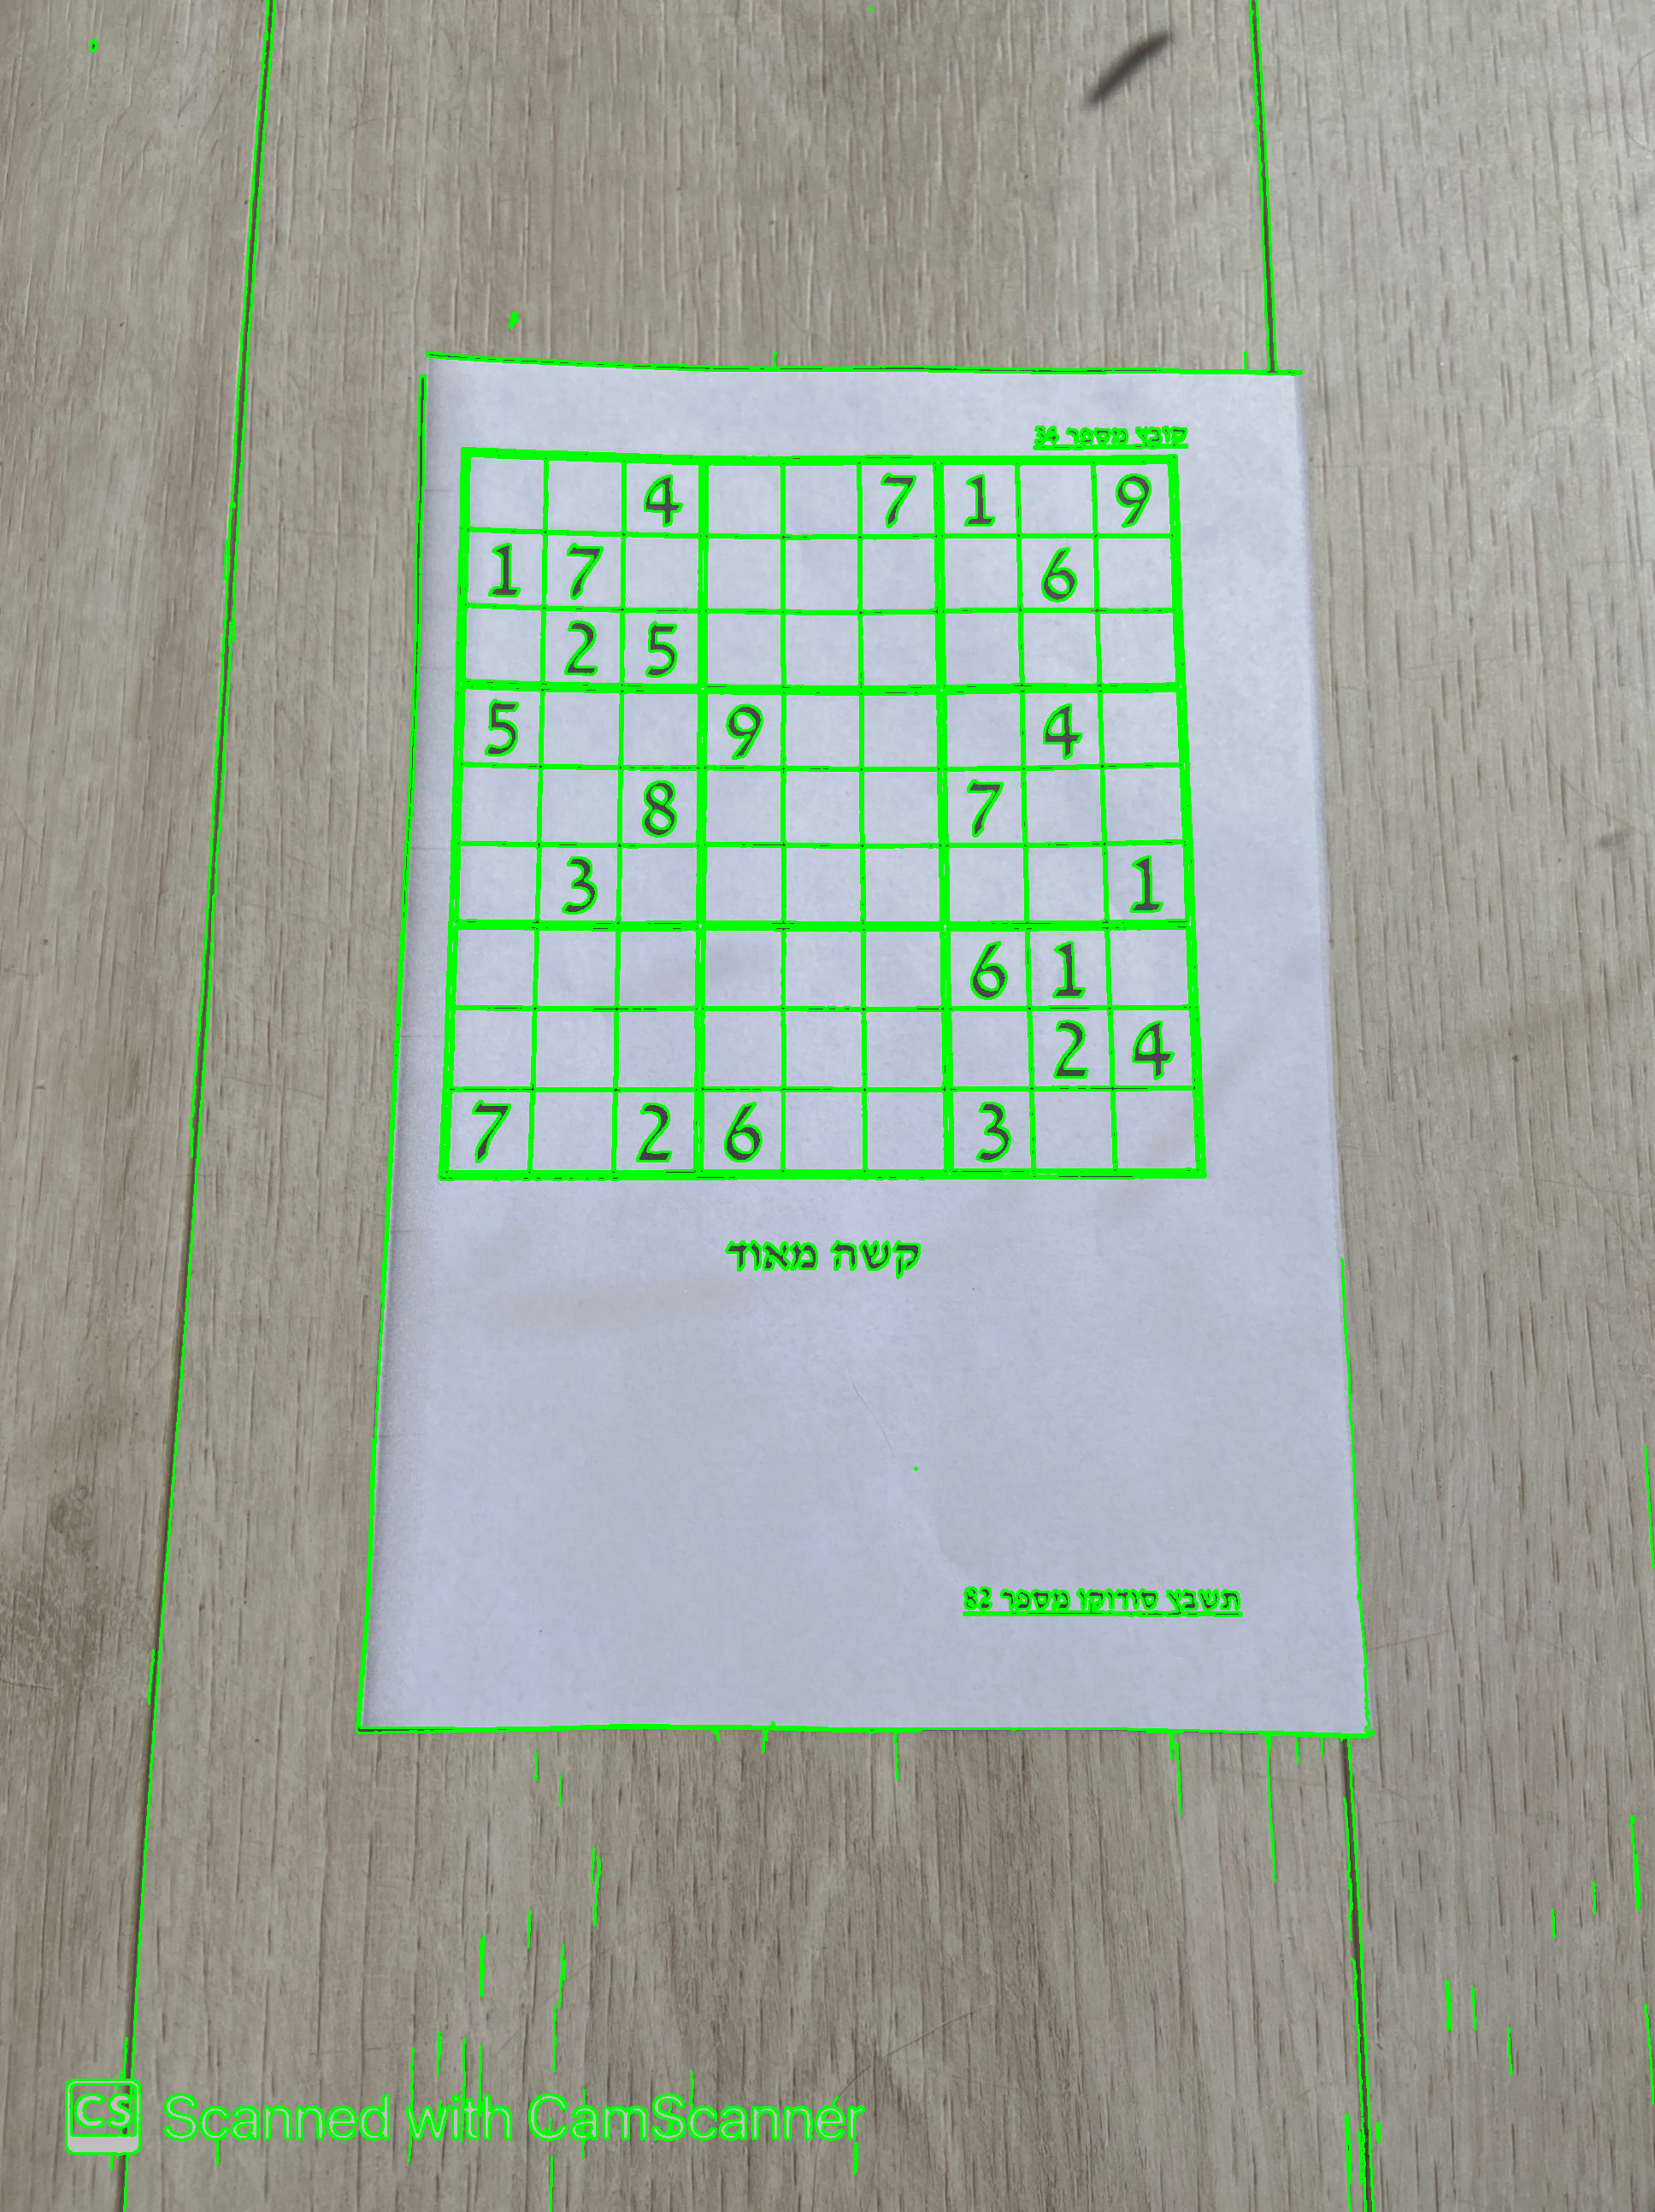

/usr/local/lib/python3.9/dist-packages/skimage/transform/radon_transform.py:75: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


After Fixing Rotation Image:


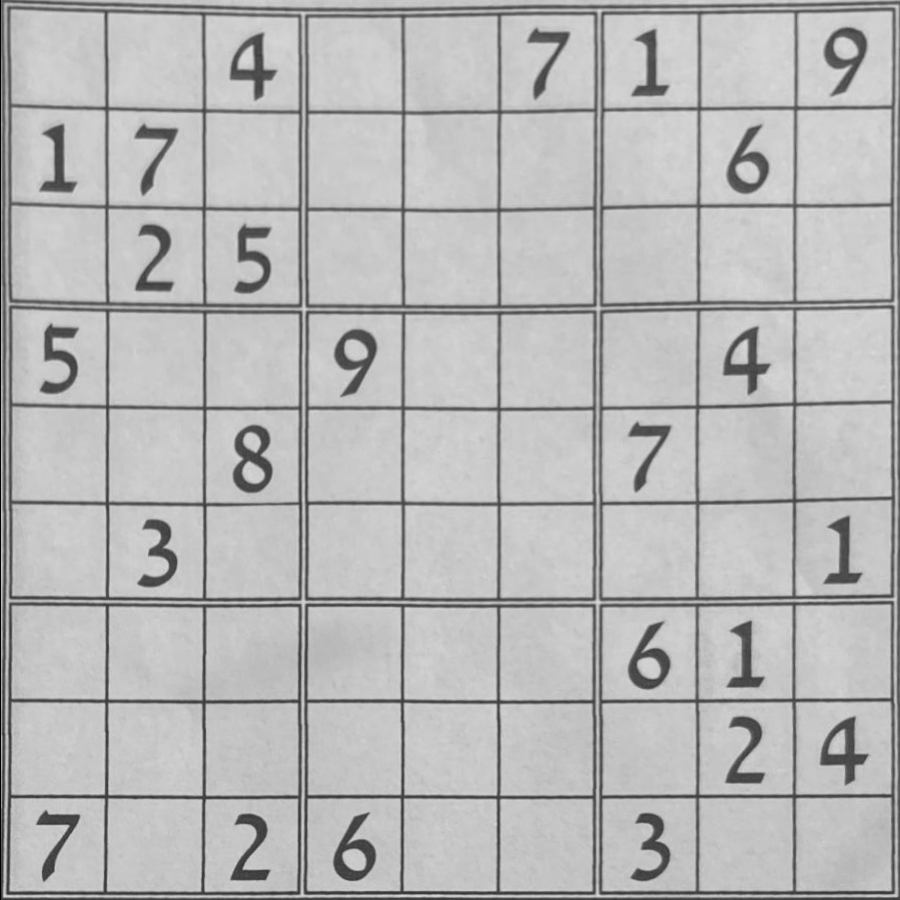

3/3 [==============================] - 1s 226ms/step
[[0 0 4 0 0 7 1 0 9]
 [1 7 0 0 0 0 0 6 0]
 [0 2 5 0 0 0 0 0 0]
 [5 0 0 9 0 0 0 4 0]
 [0 0 8 0 0 0 7 0 0]
 [0 3 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 6 1 0]
 [0 0 0 0 0 0 0 2 4]
 [7 0 2 6 0 0 3 0 0]]


In [6]:
"""

For several functions, we chose to declare the input,output types - for the simplicity and clarity.

"""

from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import imutils
import tensorflow as tf
from typing import List
from typing import Tuple
from skimage.transform import radon
import pytesseract



def get_perspective(img, location, height = 900, width = 900):
    # Transform the location of the image of the biggest rectangle found (the Sudoku board) 
    # in the original image to their corresponding points in the new plane of (height x width)
    pts1 = np.float32([location[0], location[3], location[1], location[2]]) # Get 4 vertics
    pts2 = np.float32([[0, 0], [width, 0], [0, height], [width, height]])   # Set DESIRED formation
    matrix = cv2.getPerspectiveTransform(pts1, pts2)    # Get the transform
    result = cv2.warpPerspective(img, matrix, (width, height))  # Use the transform
    return result


def split_sudoku_board(board: np.ndarray) -> List[np.ndarray]:
    # Splits the sudoku board into a list of 81 individual cells, each containing an element of the board
    rows = np.array_split(board, 9, axis=0)
    cells = []
    for row in rows:
        columns = np.array_split(row, 9, axis=1)
        for cell in columns:
            # We want to get each cell to 50x50 pixels, 
            # frame ~ image ~ frame = 1 + 48 + 1 = 50
            resized_cell = cv2.resize(cell, (48, 48))
            # Getting all values between 0-1 (instead of 0-255)
            normalized_cell = resized_cell / 255.0
            cells.append(normalized_cell)
    cv2.destroyAllWindows()
    return cells



def find_board_location(contours: List[np.ndarray]) -> np.ndarray:
    # Find the location of the sudoku board within the contours

    # Sort by size and filter 
    sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)[:15]
    board_location = None

    # Iterate over each contour
    for contour in sorted_contours:
        # Find the approximate polygonal shape, with epsilon = 15 pixels
        polygon = cv2.approxPolyDP(contour, 15, True)
        # Found the first (biggest) rectangel
        if len(polygon) == 4:
            board_location = polygon
            break
    return board_location

def locate_sudoku_board(image: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
    # Locate the sudoku board within the image and return both the sudoku board and its location in the original image
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    filtered_image = cv2.bilateralFilter(gray_image, 13, 20, 20)
    edges = cv2.Canny(filtered_image, 30, 180)
    contours, _ = cv2.findContours(edges.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    board_location = find_board_location(contours)

    # Ensure the image is in the correct orientation BEFORE proccessing it
    if board_location is None:
        image = imutils.rotate_bound(image, 90)
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        # Filter noise out of the picutre
        filtered_image = cv2.bilateralFilter(gray_image, 13, 20, 20)
        edges = cv2.Canny(filtered_image, 30, 180)
        # RETER_TREE - get the contours in a hierarchical structure
        # CHAIN_APPROX_SIMPLE - represent all lines as dots, for simplicity in the next stage 
        contours, _ = cv2.findContours(edges.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        board_location = find_board_location(contours)

    print("Contours Image:")
    cv2_imshow(cv2.drawContours(img.copy(), contours, -1, (0, 255, 0), 2))

    board = get_perspective(image, board_location)
    return board


def find_numbers(cell_arr):
  # Apply OCR model in order to predict the number in each cell / 0 if the cell is missing
  classes = np.arange(0, 10)
  model = tf.keras.models.load_model('ICBV231-10-model-OCR.h5')
  prediction = model.predict(cell_arr)
  predicted_numbers = []
  # Get classes from prediction
  for i in prediction: 
      # Returns the index of the maximum number of the array = prediction with most "confidence"
      index = (np.argmax(i)) 
      predicted_number = classes[index]
      predicted_numbers.append(predicted_number)
  return np.array(predicted_numbers).astype('uint8').reshape(9, 9)  # Use reshape to reformat the 81 cells in a sudoku format

def try_rotating(binary_board):
  h, w = binary_board.shape
  # Resize for faster processing (smaller image) 
  if (w > 640):
      I = cv2.resize(binary_board, (640, int((h / w) * 640)))
  # Demean: reduce the average from all numbers, for example:
  # instead of dealing with numbers: 999,1000,1001
  # we'll instead deal with the numbers: -1,0,1
  # which is less wide and easier to iterate
  I = I - np.mean(I)
  
  # RMS = Root Mean Square = peaks and valleys correspond with straight lines
  # In order to find the "busiest" form of rotation, RMS-wise, we perform
  # a Radon transformation, which will help us find the most "accurate" rotation
  sinogram = radon(I)
  r = np.array([np.sqrt(np.mean(np.abs(line) ** 2)) for line in sinogram.transpose()])
  rotation = np.argmax(r)

  # Rotate and save with the original resolution
  M = cv2.getRotationMatrix2D((w/2,h/2),90 - rotation,1)
  dst = cv2.warpAffine(binary_board,M,(w,h))
  # We've also found Pythesseract as a good secondary help
  res = pytesseract.image_to_osd(dst)
  # Extract the orientation information from the output
  for r in res.splitlines():
      if "Orientation in degrees:" in r:
          orientation = int(r.split(":")[1].strip())

  # Rotate the image based on the orientation information
  (h, w) = dst.shape[:2]
  center = (w // 2, h // 2)     # Find the center, so we could rotate around it
  M = cv2.getRotationMatrix2D(center, orientation, 1.0)
  dst = cv2.warpAffine(dst, M, (w, h))
  print("After Fixing Rotation Image:")
  cv2_imshow(dst)
  return dst


#########################  Set the input image.   #########################
img = cv2.imread('ICBV231-10-Stragiht_Third.jpg')
#########################                         #########################

print("Original Image:")
cv2_imshow(img)
board_img = locate_sudoku_board(img)
binary_board = cv2.cvtColor(board_img, cv2.COLOR_BGR2GRAY)  #convert the returned img from BGR to to gray


try:  # Try the image as is
  dst = try_rotating(binary_board)
except:   # Else, the image is mirrored, get x-axis-flip
  flipVertical = cv2.flip(binary_board, 0)
  try:  # Try the mirrored image
    dst = try_rotating(flipVertical)
  except:   # The image could not be processed
    print("bad image")

cells = split_sudoku_board(dst) # Split the image to 9x9 = 81 cells
cell_arr = np.array(cells)
cell_arr = cell_arr.reshape(-1, 48, 48, 1)
numbers = find_numbers(cell_arr)    # Use the OCR model to predict the numbers in each cell
print(numbers)

#Solving the Sudoku!#

We would like to give credit to the authors of this sudoku solver:


https://github.com/Lakshmi-1212/Sudoku_Solver_LP/blob/main/Solver_LP.ipynb 

In [7]:
!pip install pulp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.3/14.3 MB 68.4 MB/s eta 0:00:00


In [8]:
import pulp as plp


def add_default_sudoku_constraints(prob, grid_vars, rows, cols, grids, values):
    
    # Constraint to ensure only one value is filled for a cell
    for row in rows:
        for col in cols:
                prob.addConstraint(plp.LpConstraint(e=plp.lpSum([grid_vars[row][col][value] for value in values]),
                                        sense=plp.LpConstraintEQ, rhs=1, name=f"constraint_sum_{row}_{col}"))


    # Constraint to ensure that values from 1 to 9 is filled only once in a row        
    for row in rows:
        for value in values:
            prob.addConstraint(plp.LpConstraint(e=plp.lpSum([grid_vars[row][col][value]*value  for col in cols]),
                                        sense=plp.LpConstraintEQ, rhs=value, name=f"constraint_uniq_row_{row}_{value}"))

    # Constraint to ensure that values from 1 to 9 is filled only once in a column        
    for col in cols:
        for value in values:
            prob.addConstraint(plp.LpConstraint(e=plp.lpSum([grid_vars[row][col][value]*value  for row in rows]),
                                        sense=plp.LpConstraintEQ, rhs=value, name=f"constraint_uniq_col_{col}_{value}"))


    # Constraint to ensure that values from 1 to 9 is filled only once in the 3x3 grid       
    for grid in grids:
        grid_row  = int(grid/3)
        grid_col  = int(grid%3)

        for value in values:
            prob.addConstraint(plp.LpConstraint(e=plp.lpSum([grid_vars[grid_row*3+row][grid_col*3+col][value]*value  for col in range(0,3) for row in range(0,3)]),
                                        sense=plp.LpConstraintEQ, rhs=value, name=f"constraint_uniq_grid_{grid}_{value}"))
            
def add_prefilled_constraints(prob, input_sudoku, grid_vars, rows, cols, values):
    for row in rows:
        for col in cols:
            if(input_sudoku[row][col] != 0):
                prob.addConstraint(plp.LpConstraint(e=plp.lpSum([grid_vars[row][col][value]*value  for value in values]), 
                                                    sense=plp.LpConstraintEQ, 
                                                    rhs=input_sudoku[row][col],
                                                    name=f"constraint_prefilled_{row}_{col}"))
                
def extract_solution(grid_vars, rows, cols, values):
    solution = [[0 for col in cols] for row in rows]
    grid_list = []
    for row in rows:
        for col in cols:
            for value in values:
                if plp.value(grid_vars[row][col][value]):
                    solution[row][col] = value 
    return solution


def print_solution(solution, rows,cols):
    # Print the final result
    print(f"\nFinal result:")

    print("\n\n+ ----------- + ----------- + ----------- +",end="")
    for row in rows:
        print("\n",end="\n|  ")
        for col in cols:
            num_end = "  |  " if ((col+1)%3 == 0) else "   "
            print(solution[row][col],end=num_end)

        if ((row+1)%3 == 0):
            print("\n\n+ ----------- + ----------- + ----------- +",end="")



def solve_sudoku(input_sudoku, diagonal = False ):
    # Create the linear programming problem
    prob = plp.LpProblem("Sudoku_Solver")

    rows = range(0,9)
    cols = range(0,9)
    grids = range(0,9)
    values = range(1,10)

    # Decision Variable/Target variable
    grid_vars = plp.LpVariable.dicts("grid_value", (rows,cols,values), cat='Binary') 

    # Set the objective function
    # Sudoku works only on the constraints - feasibility problem 
    # There is no objective function that we are trying maximize or minimize.
    # Set a dummy objective
    objective = plp.lpSum(0)
    prob.setObjective(objective)

    # Create the default constraints to solve sudoku
    add_default_sudoku_constraints(prob, grid_vars, rows, cols, grids, values)
        
    # Fill the prefilled values from input sudoku as constraints
    add_prefilled_constraints(prob, input_sudoku, grid_vars, rows, cols, values)


    # Solve the problem
    prob.solve()

    # Print the status of the solution
    solution_status = plp.LpStatus[prob.status]
    print(f'Solution Status = {plp.LpStatus[prob.status]}')

    # Extract the solution if an optimal solution has been identified
    if solution_status == 'Optimal':
        solution = extract_solution(grid_vars, rows, cols, values)
        print_solution(solution, rows,cols)



solve_sudoku(input_sudoku=numbers, diagonal=False)      # Use previous detected data in order to solve the sudoku

Solution Status = Optimal

Final result:


+ ----------- + ----------- + ----------- +

|  3   8   4  |  2   6   7  |  1   5   9  |  

|  1   7   9  |  3   5   8  |  4   6   2  |  

|  6   2   5  |  1   4   9  |  8   7   3  |  

+ ----------- + ----------- + ----------- +

|  5   1   6  |  9   7   3  |  2   4   8  |  

|  4   9   8  |  5   1   2  |  7   3   6  |  

|  2   3   7  |  4   8   6  |  5   9   1  |  

+ ----------- + ----------- + ----------- +

|  9   5   3  |  8   2   4  |  6   1   7  |  

|  8   6   1  |  7   3   5  |  9   2   4  |  

|  7   4   2  |  6   9   1  |  3   8   5  |  

+ ----------- + ----------- + ----------- +